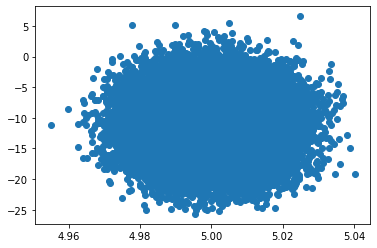

In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.lax import fori_loop as jfori
from functools import partial
import pyext.src.plot as plot
from typing import Any
State = Any
Output = Any
KeyArray = Any
DeviceArray = Any

class StateLess:
    def stateless_method(state: State, *args, **kwargs) -> (State, Output):
        pass


def outer_fun(N, inner_params):
    jax.lax.fori_loop(0, N,inner_fun, inner_params)

def norm_cond_x(key, x):
    """
    x > 0
    """
    mu = 1 / (1 + x)
    sigma = 1 / ( 2 * (1 + x) )
    norm = jax.random.normal(key)
    norm = norm*sigma + mu

def inner_fun(key, x, y):
    key = jax.random.split(key, 3)
    x = x_cond_dens(key[0])
    y = y_cond_dens(key[1])
    key = key[2]
    return key, x, y


# Funcitonal implementation
def x_cond_dens(key):
    return jax.random.normal(key) * 0.01 + 5

def y_cond_dens(key):
    return jax.random.normal(key) * 4 - 11


# X and Y are independant
def gibbsf(key: KeyArray, N=10, thin=10) -> DeviceArray:
    
    def outer_body_fun(i: int, val):
        key, samples, x, y, thin = val
        key, samples, x, y, thin = jax.lax.fori_loop(0, thin, inner_body_fun, val)
        samples = samples.at[i].set([x, y])
        return key, samples, x, y, thin

    def inner_body_fun(i: int, 
                       val: tuple[KeyArray, float, float]
                       ) -> tuple[KeyArray, float, float]:
        
        key, samples, x, y, thin = val
        key, k1, k2 = jax.random.split(key, 3)
        x = x_cond_dens(k1)
        y = y_cond_dens(k2)
        return key, samples, x, y, thin
    
    # initiate
    x = 0
    y = 0
    samples = jnp.array(np.zeros((N, 2)))
    val = key, samples, x, y, thin
    
    key, samples, x, y, thin = jax.lax.fori_loop(0, N, outer_body_fun, val)
    return samples

# imperative implementation
def gibbs(key, N=10, thin=10):
    x = 0
    y = 0
    samples = jnp.array(np.zeros((N, 2)))
    for i in range(N):
        for j in range(thin):
            key, k1, k2 = jax.random.split(key, 3)
            x = x_cond_dens(k1)
            y = y_cond_dens(k2)
        samples = samples.at[i].set([x, y])
    return samples

gibbsf_partial = partial(gibbsf, N=50000, thin=1000)
gibbsf_jit = jax.jit(gibbsf_partial)
key = jax.random.PRNGKey(5)
samples = np.array(gibbsf_jit(key))
plot.scatter(samples[:, 0], samples[:, 1])

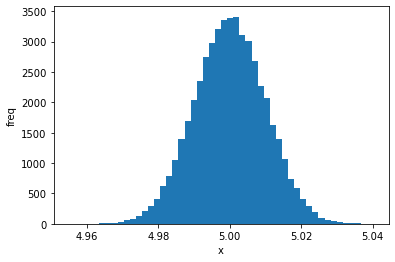

In [2]:
plot.marginal(samples[:, 0])

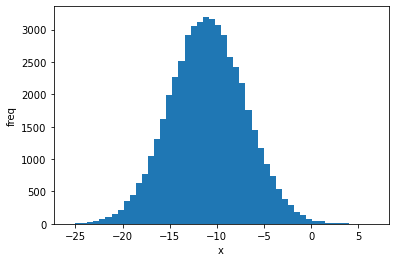

In [3]:
plot.marginal(samples[:, 1])

In [ ]:
"""
# This code will take a very long time to jit compile
# because the gibbs function uses python for loops
# instead of jax.lax.fori_loop

gibbs_partial = partial(gibbs, N=50000, thin=1000)
gibbs_jit = jax.jit(gibbs_partial)
key = jax.random.PRNGKey(5)
samples = np.array(gibbs_jit(key))
plot.scatter(samples[:, 0], samples[:, 1])
"""

In [3]:
key = jax.random.PRNGKey(5)
gibbs_jit = jax.jit(gibbs)
samples = gibbs_jit(key)

In [4]:
key = jax.random.PRNGKey(5)
gibbsf_jit = jax.jit(gibbsf)
samplesf = gibbsf_jit(key)

In [6]:
samples == samplesf

DeviceArray([[ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True]], dtype=bool)

In [7]:
key2 = jax.random.PRNGKey(17)
samples = gibbs_jit(key2)
key2 = jax.random.PRNGKey(17)
samplesf = gibbsf_jit(key2)

In [8]:
samples == samplesf

DeviceArray([[ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True]], dtype=bool)

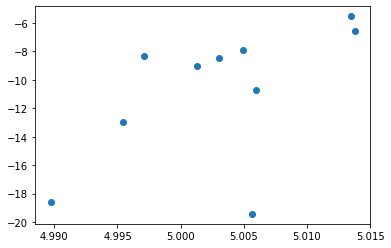

In [11]:
plt.scatter(samples[:, 0], samples[:, 1])

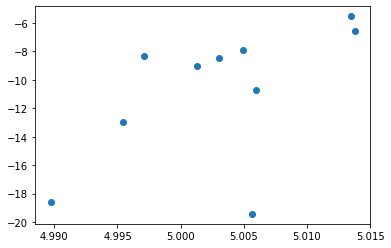

In [13]:
plt.scatter(samplesf[:, 0], samplesf[:, 1])

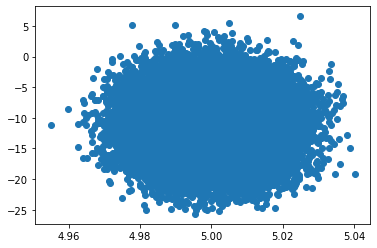

In [4]:
gibbs_partial = partial(gibbsf, N=50000, thin=1000)
gibbsf_jit = jax.jit(gibbs_partial)
key = jax.random.PRNGKey(5)
samples = np.array(gibbsf_jit(key))
plt.scatter(samples[:, 0], samples[:, 1])

In [15]:
import pyext.src.plot as plot
plot.marginal(samples[:, 0])

AttributeError: module 'pyext.src.plot' has no attribute 'marginal'

In [ ]:
try:  # Doesn't work; fori_loop requires f(i, val)
    f = lambda x: x+1
    jax.lax.fori_loop(0, 100, f, 0)
except TypeError:
    # Works
    # Can jit through the funciton
    def iwrapper(f):
        def wrap(i, val):
            return f(val)
        return wrap
    f = iwrapper(lambda x: x+1)
    print(jax.lax.fori_loop(0, 10, f, 0))
    print(jax.jit(lambda : jax.lax.fori_loop(0, 10, f, 0))().block_until_ready())

In [270]:
def f(x: KeyArray):
    def g(x):
        return 2*x
    return g(x) + 1
f = jax.jit(f)


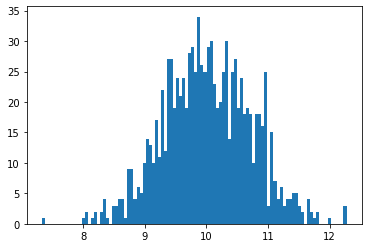

In [67]:
plt.hist(samples, bins=100)
plt.show()